In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Scanning Astra evaluations

In [2]:
from astra import template_dir, evaluate_astra_with_distgen

import matplotlib.pyplot as plt

import numpy as np
import os

In [3]:
# Input files
ASTRA_IN = os.path.join(template_dir, 'dcgun/astra.in')
DISTGEN_IN = os.path.join(template_dir, 'dcgun/distgen.yaml')

In [4]:
# Run Astra with Distgen

# Basic settings
settings0 = {'zstop':1, 'zemit':10, 'zphase':10, 'phases':True}
settings0['beam:particle_count'] = 2000

# Solenoid field
settings0['maxb(1)'] = 0.04

In [5]:
# This is the basic function we will use
outputs = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN)
outputs

/Users/chrisonian/Code/miniconda3/envs/devel/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': -9.7076e-09,
 'end_sigma_x': 0.00034249000000000004,
 'end_sigma_xp': 0.00058495,
 'end_norm_emit_x': 1.7523e-07,
 'end_cov_x__xp': 1.7203272700000003e-07,
 'end_mean_y': -5.8687999999999994e-09,
 'end_sigma_y': 0.00034237,
 'end_sigma_yp': 0.00058437,
 'end_norm_emit_y': 1.7449e-07,
 'end_cov_y__yp': 1.71972451e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 0.0021987,
 'end_sigma_energy': 1.7899,
 'end_norm_emit_z': 0.0039355,
 'end_cov_z__energy': -2.089776402e-05,
 'end_n_particle_loss': 0,
 'end_higher_order_energy_spread': 1.78989411872844,
 'fingerprint': '06a021e52d1b0307fa4118b5bd2bd41b'}

In [6]:
# Make a bare minimum function to evaluate
def f(b):
    s = settings0.copy()
    s['maxb(1)'] = b
    return evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                          distgen_input_file=DISTGEN_IN)
# Make a list to scan
blist = np.linspace(0, 0.1, 20)
f(0)

{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': -1.0074000000000001e-08,
 'end_sigma_x': 0.00061591,
 'end_sigma_xp': 0.00065659,
 'end_norm_emit_x': 1.7486999999999998e-07,
 'end_cov_x__xp': 3.912075547e-07,
 'end_mean_y': -5.3179000000000004e-09,
 'end_sigma_y': 0.00061616,
 'end_sigma_yp': 0.0006571200000000001,
 'end_norm_emit_y': 1.7486999999999998e-07,
 'end_cov_y__yp': 3.9171139680000005e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 0.0021987,
 'end_sigma_energy': 1.7899,
 'end_norm_emit_z': 0.0039355,
 'end_cov_z__energy': -2.0935581659999997e-05,
 'end_n_particle_loss': 0,
 'end_higher_order_energy_spread': 1.789895044634527,
 'fingerprint': 'f0240cd0aa4c4fdc6a82129357efe50d'}

In [7]:
# Get a parallel executor
from concurrent.futures import ProcessPoolExecutor
executor =  ProcessPoolExecutor()

In [8]:
# Make a map object. Note that this does not execute immediately.
results = executor.map(f, blist)

In [9]:
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)


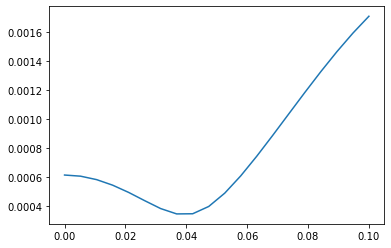

In [10]:
# Simple plot
plt.plot(blist, [o['end_sigma_x'] for o in outputs])

# Better: robust evaluation, form dataset 

In [11]:
from tempfile import TemporaryDirectory
SCRATCH=TemporaryDirectory()

In [12]:
# Make a robust evaluate
def evaluate(b):
    try:
        s = settings0.copy()
        s['maxb(1)'] = b
        output = evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN, archive_path=SCRATCH.name)
        # Add the input
        output['maxb(1)'] = b
        output['Exception'] = False
    except:
        output = {}
        output['maxb(1)'] = b
        output['Exception'] = True
        
    return output

In [13]:
SCRATCH.name

'/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpfdrnr0am'

In [14]:
# This will cause a crash in Astra
evaluate(1e9)

Run Aborted too many indices for array


/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py:136: UserWarning: loadtxt: Empty input file: "/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmps0mg3pwu/astra.Xemit.001"
  data = np.loadtxt(filePath)
/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py:136: UserWarning: loadtxt: Empty input file: "/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmps0mg3pwu/astra.Yemit.001"
  data = np.loadtxt(filePath)
/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py:136: UserWarning: loadtxt: Empty input file: "/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmps0mg3pwu/astra.Zemit.001"
  data = np.loadtxt(filePath)


{'maxb(1)': 1000000000.0, 'Exception': True}

In [15]:
# Get a new executor
executor =  ProcessPoolExecutor()

# Make a map object. Note that this does not execute immediately.

blist[-1] = 1e9 # Add something that will crash
results = executor.map(evaluate, blist)
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)

/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py:136: UserWarning: loadtxt: Empty input file: "/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpi06e4ay0/astra.Xemit.001"
  data = np.loadtxt(filePath)
/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py:136: UserWarning: loadtxt: Empty input file: "/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpi06e4ay0/astra.Yemit.001"
  data = np.loadtxt(filePath)
/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py:136: UserWarning: loadtxt: Empty input file: "/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpi06e4ay0/astra.Zemit.001"
  data = np.loadtxt(filePath)


Run Aborted too many indices for array


In [16]:
# Archive files are here
os.listdir(SCRATCH.name)

['7313cfc7b431a7dfc344a28b6d15a56e.h5',
 '8c0c749b1ed40b462c5fa0dbef91eb8c.h5',
 'e932ccaa14b0f08f3a57910683e98452.h5',
 '63537642b71073566f279ee9b34c2952.h5',
 'f4c021cfaf6a19e52e0299ac11f8ddc7.h5',
 'dc0a86b8498795999665ee5f5c8f2d43.h5',
 '06f7a7fca1e1934cf1e3c2f094691a53.h5',
 '044adbca9eb4a39041acf46f55c350f7.h5',
 '4a3d9b4b165dba83bdf66f765537b7a3.h5',
 '374656d86cf85f8db59d4cc4f546eb15.h5',
 '1715c2fceea1f056769e96ec4a56dcc2.h5',
 '5491529fcecb9f86bd70b37ddf595f99.h5',
 '2ed6a35e3df5354c0b17521c17238e31.h5',
 'e3598abee32bc884e6df989bd34120c5.h5',
 '7dc571cf5fd92eb07188318b6e336793.h5',
 'afd7d6cc242985b697e6580d44947968.h5',
 '5a515b6e346adaf1d5212d85f9a95cdb.h5',
 'ff743c1108264da68ca3aac4741587ff.h5',
 '0e053c084fd780ba332c13bcf6e11323.h5']

# Pandas 

In [17]:
import pandas as pd

In [18]:
# Make a DataFrame
df = pd.DataFrame(outputs)
df

,error,end_mean_z,end_mean_t,end_mean_x,end_sigma_x,end_sigma_xp,end_norm_emit_x,end_cov_x__xp,end_mean_y,end_sigma_y,...,end_sigma_z,end_sigma_energy,end_norm_emit_z,end_cov_z__energy,end_n_particle_loss,end_higher_order_energy_spread,fingerprint,archive,maxb(1),Exception
0,False,1.0,4.015600e-09,-1.007400e-08,0.000616,0.000657,1.748700e-07,3.912076e-07,-5.317900e-09,0.000616,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789895,f4c021cfaf6a19e52e0299ac11f8ddc7,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,0.000000e+00,False
1,False,1.0,4.015600e-09,-9.416600e-09,0.000608,0.000647,1.749600e-07,3.800855e-07,-6.280500e-09,0.000608,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789895,0e053c084fd780ba332c13bcf6e11323,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,5.263158e-03,False
2,False,1.0,4.015600e-09,-8.774100e-09,0.000584,0.000621,1.750400e-07,3.479737e-07,-6.843500e-09,0.000584,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789895,4a3d9b4b165dba83bdf66f765537b7a3,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.052632e-02,False
3,False,1.0,4.015600e-09,-8.262100e-09,0.000546,0.000581,1.751100e-07,3.001472e-07,-7.049500e-09,0.000545,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789895,63537642b71073566f279ee9b34c2952,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.578947e-02,False
4,False,1.0,4.015600e-09,-7.983100e-09,0.000496,0.000536,1.751700e-07,2.450736e-07,-6.969500e-09,0.000495,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789895,e932ccaa14b0f08f3a57910683e98452,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.105263e-02,False
5,False,1.0,4.015600e-09,-8.002300e-09,0.000439,0.000499,1.752100e-07,1.937792e-07,-6.697400e-09,0.000438,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789894,afd7d6cc242985b697e6580d44947968,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.631579e-02,False
6,False,1.0,4.015600e-09,-8.369100e-09,0.000384,0.000492,1.752300e-07,1.590813e-07,-6.341300e-09,0.000384,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789894,5a515b6e346adaf1d5212d85f9a95cdb,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.157895e-02,False
7,False,1.0,4.015600e-09,-9.090100e-09,0.000348,0.000534,1.752300e-07,1.546022e-07,-6.012900e-09,0.000347,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789894,06f7a7fca1e1934cf1e3c2f094691a53,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.684211e-02,False
8,False,1.0,4.015600e-09,-1.017800e-08,0.000349,0.000629,1.752200e-07,1.937337e-07,-5.824600e-09,0.000348,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789894,2ed6a35e3df5354c0b17521c17238e31,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.210526e-02,False
9,False,1.0,4.015600e-09,-1.155300e-08,0.000399,0.000768,1.751800e-07,2.885824e-07,-5.909900e-09,0.000399,...,0.002199,1.7899,0.003935,-0.000021,0.0,1.789894,dc0a86b8498795999665ee5f5c8f2d43,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.736842e-02,False


In [19]:
# Get all runs without an exeption
filtered_df=df[~df['Exception']]

# Visualize with Bokeh

In [20]:
from bokeh.plotting import figure, output_notebook, show

from bokeh.models import ColumnDataSource

# Allows plots to show up in the notebook
output_notebook()

Loading BokehJS ...

In [21]:
# Form a Bokeh style data source
source = ColumnDataSource(filtered_df)
source.column_names

['index',
 'error',
 'end_mean_z',
 'end_mean_t',
 'end_mean_x',
 'end_sigma_x',
 'end_sigma_xp',
 'end_norm_emit_x',
 'end_cov_x__xp',
 'end_mean_y',
 'end_sigma_y',
 'end_sigma_yp',
 'end_norm_emit_y',
 'end_cov_y__yp',
 'end_mean_kinetic_energy',
 'end_sigma_z',
 'end_sigma_energy',
 'end_norm_emit_z',
 'end_cov_z__energy',
 'end_n_particle_loss',
 'end_higher_order_energy_spread',
 'fingerprint',
 'archive',
 'maxb(1)',
 'Exception']

In [22]:
# A simple plot
p = figure()
p.circle(x='maxb(1)', y='end_sigma_x', source=source)
show(p)

In [23]:
# Fancier plot

from bokeh.models.tools import HoverTool

hover = HoverTool()


hover.tooltips=[
    ('sigma_x', '@end_sigma_x'),
    ('norm_emit_x', '@end_norm_emit_x'),
    ('archive', '@archive')
]
p = figure(tools='tap')
p.circle(x='maxb(1)', y='end_sigma_x', source=source, size=10, color='green')

p.add_tools(hover)

show(p)

In [24]:
# Load all archives
from astra import Astra
Alist = []
for a in filtered_df['archive']:
    A = Astra()
    A.load_archive(a)
    Alist.append(A)

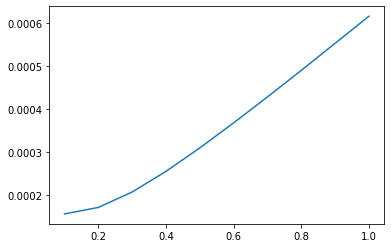

In [25]:
plt.plot(
    Alist[0].output['stats']['mean_z'],
    Alist[0].output['stats']['sigma_x']
)